In [ ]:
#Preprocessing DSC 540

In [1]:
# Check scikit-learn version
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Check imbalanced-learn version
import imblearn
print(f"imbalanced-learn version: {imblearn.__version__}")

scikit-learn version: 1.3.2
imbalanced-learn version: 0.11.0


In [2]:
#!pip install --upgrade scikit-learn==1.3.2
#!pip install --upgrade imbalanced-learn==0.11.0

In [3]:
import pkg_resources
import sys
if 'parse_version' not in dir(sys.modules.get('sklearn.utils', {})):
    import sklearn.utils
    sklearn.utils.parse_version = pkg_resources.parse_version

/var/folders/rr/5jvnljv55dz8x2s6v477rzlc0000gn/T/ipykernel_1692/899509318.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [4]:
# installing imbalanced-learn package that provides the imblean module, which includes tools of rhandling imbalanced datasets such as SMOTE and RandomUnderSampler. 
# !pip install imbalanced-learn

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [6]:
df=pd.read_csv("/Users/user/Desktop/DSC 540 Advanced Machine Learning/Final Project/Chronic_Kidney_Dsease_data.csv") 
# Replace with your location
pd.set_option("display.max_columns", None)

In [7]:
df.head()

PatientID  Age  Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0          1   71       0          0                    0               2   
1          2   34       0          0                    1               3   
2          3   80       1          1                    0               1   
3          4   40       0          2                    0               1   
4          5   43       0          1                    1               2   

         BMI  Smoking  AlcoholConsumption  PhysicalActivity  DietQuality  \
0  31.069414        1            5.128112          1.676220     0.240386   
1  29.692119        1           18.609552          8.377574     6.503233   
2  37.394822        1           11.882429          9.607401     2.104828   
3  31.329680        0           16.020165          0.408871     6.964422   
4  23.726311        0            7.944146          0.780319     3.097796   

   SleepQuality  FamilyHistoryKidneyDisease  FamilyHistoryHypertension  \
0      4.076434                           0                          0   
1      7.652813                           1                          1   
2      4.392786                           0                          0   
3      6.282274                           0                          0   
4      4.021639                           0                          0   

   FamilyHistoryDiabetes  PreviousAcuteKidneyInjury  UrinaryTractInfections  \
0                      0                          0                       0   
1                      0                          0                       0   
2                      0                          0                       0   
3                      0                          0                       0   
4                      0                          0                       0   

   SystolicBP  DiastolicBP  FastingBloodSugar     HbA1c  SerumCreatinine  \
0         113           83          72.510788  9.212397         4.962531   
1         120           67         100.848875  4.604989         3.156799   
2         147          106         160.989441  5.432599         3.698236   
3         117           65         188.506620  4.144466         2.868468   
4          98           66          82.156699  4.262979         3.964877   

   BUNLevels        GFR  ProteinInUrine         ACR  SerumElectrolytesSodium  \
0  25.605949  45.703204        0.744980  123.849426               137.652501   
1  31.338166  55.784504        3.052317   88.539095               138.141335   
2  39.738169  67.559032        1.157839   21.170892               142.970116   
3  21.980958  33.202542        3.745871  123.779699               137.106913   
4  12.216366  56.319082        2.570993  184.852046               140.627812   

   SerumElectrolytesPotassium  SerumElectrolytesCalcium  \
0                    3.626058                 10.314420   
1                    5.332871                  9.604196   
2                    4.330891                  9.885786   
3                    3.810741                  9.995894   
4                    4.866765                  8.907622   

   SerumElectrolytesPhosphorus  HemoglobinLevels  CholesterolTotal  \
0                     3.152648         16.114679        207.728670   
1                     2.855443         15.349205        189.450727   
2                     4.353513         13.018834        284.137622   
3                     4.016134         15.056339        235.112124   
4                     3.947907         16.690561        258.277566   

   CholesterolLDL  CholesterolHDL  CholesterolTriglycerides  ACEInhibitors  \
0       85.863656       21.967957                212.095215              0   
1       86.378670       87.569756                255.451314              0   
2      132.269872       20.049798                251.902583              0   
3       93.443669       58.260291                392.338425              0   
4      171.758356       21.583213                370.523877

In [8]:
df.shape

(1659, 54)

In [9]:
df.drop("DoctorInCharge", axis=1, inplace=True)

In [10]:
#Removed Doctor in charge as it is not necessary for the ML project and it is confidential for HIPPA as well

In [11]:
#PatientID was selected which may undicated a potential issue with the data. Considering this it will be removed for future use

In [12]:
df = df.drop('PatientID', axis=1)

In [13]:
#copy df and add for understanding 
def ef(df):
    df_eng = df.copy()
    if 'GFR' not in df.columns and all(col in df.columns for col in ['SerumCreatinine', 'Age', 'Gender']):
        gender_factor = (df_eng['Gender'] == 1).astype(int) * 0.85 + 0.15
        df_eng['eGFR_calculated'] = 175 * (df_eng['SerumCreatinine'] ** -1.154) * (df_eng['Age'] ** -0.203) * gender_factor
    if 'BMI' in df.columns: #BMI Categories based off medical journals
        bins = [0, 18.5, 25, 30, 100]
        labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
        df_eng['BMI_Category'] = pd.cut(df_eng['BMI'], bins=bins, labels=labels)
    # CKD stages
    if 'GFR' in df.columns:
        bins = [0, 15, 30, 45, 60, 90, 1000]
        labels = ['Stage 5', 'Stage 4', 'Stage 3B', 'Stage 3A', 'Stage 2', 'Stage 1']
        df_eng['CKD_Stage'] = pd.cut(df_eng['GFR'], bins=bins, labels=labels)
    if all(col in df.columns for col in ['Age', 'SerumCreatinine']):
        df_eng['Age_Creatinine'] = df_eng['Age'] * df_eng['SerumCreatinine']
    if all(col in df.columns for col in ['Smoking', 'BMI']):
        df_eng['Smoking_BMI'] = df_eng['Smoking'] * df_eng['BMI']
    if all(col in df.columns for col in ['SystolicBP', 'DiastolicBP']):
        df_eng['Pulse_Pressure'] = df_eng['SystolicBP'] - df_eng['DiastolicBP']
        df_eng['Mean_Arterial_Pressure'] = df_eng['DiastolicBP'] + (df_eng['Pulse_Pressure'] / 3)
    risk_factors = ['FamilyHistoryKidneyDisease', 'Smoking', 'FamilyHistoryDiabetes', 
                   'FamilyHistoryHypertension', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections']
    risk_factors_present = [col for col in risk_factors if col in df.columns]
    if risk_factors_present:
        df_eng['Risk_Score'] = df_eng[risk_factors_present].sum(axis=1)
    return df_eng

In [14]:
#handle outliers in the new df 
def ho(df, cols_to_check=None):
    df_clean = df.copy()
    if cols_to_check is None:
        cols_to_check = df.select_dtypes(include=['float64', 'int64']).columns
    for col in cols_to_check:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
            df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound
    return df_clean

In [15]:
def sf(X, y, method='correlation', k=15):
    if method == 'correlation':
        if not isinstance(y, pd.Series):
            y = pd.Series(y, name='target')
        elif y.name is None:
            y = y.copy()
            y.name = 'target'
        correlations = {}
        for col in X.columns:
            corr_value = abs(X[col].corr(y))
            correlations[col] = corr_value
        corr_df = pd.DataFrame(list(correlations.items()), 
                              columns=['feature', 'correlation'])
        corr_df = corr_df.set_index('feature')
        selected_features = corr_df.sort_values('correlation', 
                                              ascending=False).head(k).index.tolist()
    elif method == 'selectkbest':
        selector = SelectKBest(f_classif, k=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()].tolist()
    elif method == 'rfe':
        estimator = RandomForestClassifier(random_state=42)
        selector = RFE(estimator, n_features_to_select=k)
        selector.fit(X, y)
        selected_features = X.columns[selector.get_support()].tolist()
    return selected_features


Selected 15 features: ['SerumCreatinine', 'GFR', 'Age_Creatinine', 'CKD_Stage_Stage 1', 'Itching', 'FastingBloodSugar', 'MuscleCramps', 'BUNLevels', 'ProteinInUrine', 'CKD_Stage_Stage 4', 'CKD_Stage_Stage 3A', 'BMI_Category_Normal', 'SystolicBP', 'Mean_Arterial_Pressure', 'BMI_Category_Obese']

Detected class imbalance, apply SMOTE...
Balanced dataset shape: (3048, 15)


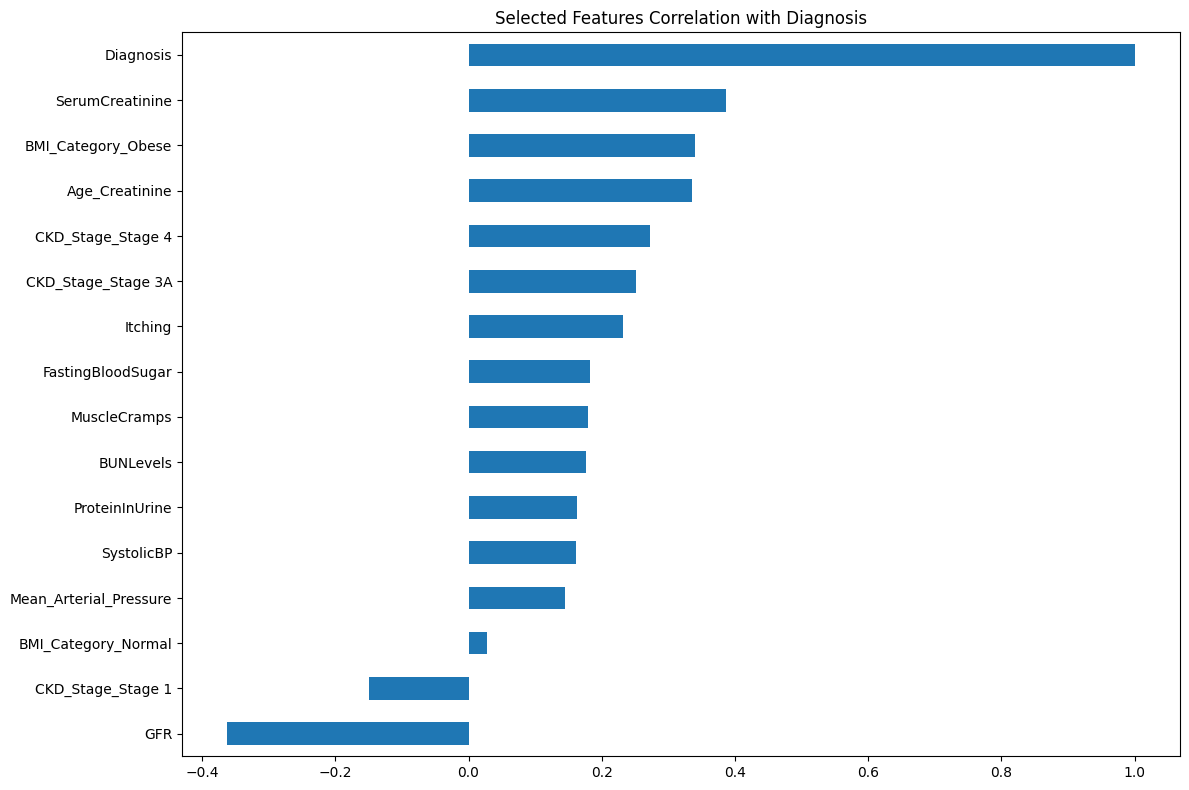

In [16]:
def pkd(df, target_col='Diagnosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    X2 = ef(X)
    XC = ho(X2)
    cc = XC.select_dtypes(include=['object', 'category']).columns
    nc = XC.select_dtypes(include=['int64', 'float64']).columns
    if len(cc) > 0:
        XE= pd.get_dummies(XC, columns=cc, drop_first=True)
    else:
        X_encoded = XC
    scaler = StandardScaler()
    XS= XE.copy()
    XS[nc] = scaler.fit_transform(XE[nc])
    nf = min(15, XS.shape[1])
    selected_features = sf(XS, y, method='correlation', k=nf)
    X_selected = XS[selected_features]
    print(f"\nSelected {len(selected_features)} features: {selected_features}")
    cd = y.value_counts(normalize=True)
    imbalanced = any(cd < 0.3)
    if imbalanced:
        print("\nDetected class imbalance, apply SMOTE...")
        try:
            smote = SMOTE(random_state=42)
            X_balanced, y_balanced = smote.fit_resample(X_selected, y)
            print(f"Balanced dataset shape: {X_balanced.shape}")
        except ValueError:
            print("SMOTE could not be applied")
            X_balanced, y_balanced = X_selected, y
    else:
        X_balanced, y_balanced = X_selected, y
    return X_balanced, y_balanced, selected_features
X_preprocessed, y_preprocessed, selected_features = pkd(df)
result_df = pd.concat([X_preprocessed, y_preprocessed], axis=1)
plt.figure(figsize=(12, 8))
corr_with_target = result_df[selected_features + ['Diagnosis']].corr()['Diagnosis'].sort_values()
corr_with_target.plot(kind='barh')
plt.title('Selected Features Correlation with Diagnosis')
plt.tight_layout()
plt.show()

In [20]:
# Combine the features and target variable
result_df = pd.concat([X_preprocessed, y_preprocessed], axis=1)

# Display basic information about the dataframe
print(result_df.info())

# Show the first few rows
print("\nFirst few rows:")
print(result_df.head())

# Show class distribution
print("\nClass Distribution:")
print(result_df['Diagnosis'].value_counts(normalize=True))

# Save to CSV
result_df.to_csv('balanced_ckd_dataset.csv', index=False)
print("\nDataset saved to 'balanced_ckd_dataset.csv'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SerumCreatinine         3048 non-null   float64
 1   GFR                     3048 non-null   float64
 2   Age_Creatinine          3048 non-null   float64
 3   CKD_Stage_Stage 1       3048 non-null   uint8  
 4   Itching                 3048 non-null   float64
 5   FastingBloodSugar       3048 non-null   float64
 6   MuscleCramps            3048 non-null   float64
 7   BUNLevels               3048 non-null   float64
 8   ProteinInUrine          3048 non-null   float64
 9   CKD_Stage_Stage 4       3048 non-null   uint8  
 10  CKD_Stage_Stage 3A      3048 non-null   uint8  
 11  BMI_Category_Normal     3048 non-null   uint8  
 12  SystolicBP              3048 non-null   float64
 13  Mean_Arterial_Pressure  3048 non-null   float64
 14  BMI_Category_Obese      3048 non-null   

Direct Kidney Function Indicators:
SerumCreatinine: A key blood marker for kidney function
GFR: Glomerular Filtration Rate - the gold standard measure of kidney function used for catefories
BUNLevels: Blood Urea Nitrogen - kidney function marker
ProteinInUrine: kidney damage sign 

CKD Staging Information: (GFR categories created)
CKD_Stage_Stage 1: Early kidney disease (GFR > 90 with signs of kidney damage)
CKD_Stage_Stage 3A: Moderate kidney disease (GFR 45-59)
CKD_Stage_Stage 4: Severe kidney disease (GFR 15-29)

Cardiovascular/Metabolic Measures:
SystolicBP: Upper blood pressure reading
Mean_Arterial_Pressure: average blood pressure during cardiac cycle
FastingBloodSugar: Important for diabetes assessment -huge kidney disease risk 

Body Composition Categories: (prior categories created)
BMI_Category_Normal: BMI between 18.5-25
BMI_Category_Obese: BMI over 30

Symptom Indicators:
Itching: can be common in advanced kidney disease
MuscleCramps: can be seen in electrolyte imbalances from kidney dysfunction

Feature Interaction:
Age_Creatinine: combine age and creatine

Positive correlations would indicate features that are associated with a higher likelihood of kidney disease:
- SerumCreatinine and Age_Creatinine have strong positive correlations (~0.4), meaning higher values are strongly associated with kidney disease diagnosis
- Itching, FastingBloodSugar, MuscleCramps, BUNLevels, ProteinInUrine all show positive correlations (~0.2-0.3)
- SystolicBP, CKD_Stage_Stage 4, CKD_Stage_Stage 3A, and Mean_Arterial_Pressure also show positive correlations
- BMI_Category_Obese shows a very slight positive correlation


Negative correlations would indicate features that are associated with a lower likelihood of kidney disease:
- GFR has a strong negative correlation (~-0.25), meaning higher GFR values are associated with no kidney disease (which makes clinical sense)
- CKD_Stage_Stage 1 has a similar negative correlation, indicating early stage kidney disease is negatively correlated with a positive diagnosis
- BMI_Category_Normal is negatively correlated, suggesting normal BMI is associated with a lower chance of kidney disease

In [31]:
# Examine final preprocessed data
print("Shape of preprocessed features:", X_preprocessed.shape)
print("Final selected features:", selected_features)
print("Sample of preprocessed data:")
X_preprocessed.head()

Shape of preprocessed features: (1659, 15)
Final selected features: ['SerumCreatinine', 'GFR', 'Age_Creatinine', 'CKD_Stage_Stage 1', 'Itching', 'FastingBloodSugar', 'MuscleCramps', 'BUNLevels', 'ProteinInUrine', 'CKD_Stage_Stage 4', 'CKD_Stage_Stage 3A', 'BMI_Category_Normal', 'SystolicBP', 'Mean_Arterial_Pressure', 'BMI_Category_Obese']
Sample of preprocessed data:


SerumCreatinine       GFR  Age_Creatinine  CKD_Stage_Stage 1   Itching  \
0         1.677841 -0.703221        2.153159                  0  0.868676   
1         0.306508 -0.367645       -0.444441                  0  0.618802   
2         0.717693  0.024294        1.554345                  0 -1.010611   
3         0.087540 -1.119330       -0.365906                  0  0.702294   
4         0.920190 -0.349850        0.225171                  0 -0.521515   

   FastingBloodSugar  MuscleCramps  BUNLevels  ProteinInUrine  \
0          -1.642006      0.490246  -0.154027       -1.206656   
1          -0.866725     -0.653308   0.293655        0.385425   
2           0.778617      1.205499   0.949690       -0.921780   
3           1.531439     -0.666063  -0.437137        0.863983   
4          -1.378111      1.617107  -1.199745        0.053308   

   CKD_Stage_Stage 4  CKD_Stage_Stage 3A  BMI_Category_Normal  SystolicBP  \
0                  0                   1                    0   -0.830450   
1                  0                   1                    0   -0.558711   
2                  0                   0                    0    0.489425   
3                  0                   0                    0   -0.675170   
4                  0                   1                    1   -1.412747   

   Mean_Arterial_Pressure  BMI_Category_Obese  
0               -0.795735                   1  
1               -1.380502                   0  
2                1.075521                   1  
3               -1.544237                   1  
4               -1.941878                   0

In [32]:
X_preprocessed

SerumCreatinine       GFR  Age_Creatinine  CKD_Stage_Stage 1   Itching  \
0            1.677841 -0.703221        2.153159                  0  0.868676   
1            0.306508 -0.367645       -0.444441                  0  0.618802   
2            0.717693  0.024294        1.554345                  0 -1.010611   
3            0.087540 -1.119330       -0.365906                  0  0.702294   
4            0.920190 -0.349850        0.225171                  0 -0.521515   
...               ...       ...             ...                ...       ...   
1654        -0.426647  0.459868        0.508633                  0 -1.012606   
1655        -1.646880  1.704213       -1.371632                  1  0.992049   
1656        -1.690321 -1.582661       -1.112658                  0 -1.750018   
1657        -1.014015  0.064609       -0.229364                  0 -0.563310   
1658        -0.023355 -1.382174       -0.601013                  0  1.471955   

      FastingBloodSugar  MuscleCramps  BUNLevels  ProteinInUrine  \
0             -1.642006      0.490246  -0.154027       -1.206656   
1             -0.866725     -0.653308   0.293655        0.385425   
2              0.778617      1.205499   0.949690       -0.921780   
3              1.531439     -0.666063  -0.437137        0.863983   
4             -1.378111      1.617107  -1.199745        0.053308   
...                 ...           ...        ...             ...   
1654           1.720950      1.701580  -0.341374        0.298603   
1655          -1.612030     -1.510828  -0.033809        0.691996   
1656           0.835929     -0.613936   0.168350        0.728577   
1657          -0.922934     -1.613263  -0.921917        0.912842   
1658           0.783859      1.160579  -0.434287       -1.488893   

      CKD_Stage_Stage 4  CKD_Stage_Stage 3A  BMI_Category_Normal  SystolicBP  \
0                     0                   1                    0   -0.830450   
1                     0                   1                    0   -0.558711   
2                     0                   0                    0    0.489425   
3                     0                   0                    0   -0.675170   
4                     0                   1                    1   -1.412747   
...                 ...                 ...                  ...         ...   
1654                  0                   0                    0   -0.170512   
1655                  0                   0                    0   -0.286972   
1656                  1                   0                    1   -0.636350   
1657                  0                   0                    1    1.110542   
1658                  1                   0                    1   -0.908089   

      Mean_Arterial_Pressure  BMI_Category_Obese  
0                  -0.795735                   1  
1                  -1.380502                   0  
2                   1.075521                   1  
3                  -1.544237                   1  
4                  -1.941878                   0  
...                      ...                 ...  
1654               -0.117405                   1  
1655                0.467363                   0  
1656                0.210065                   0  
1657                0.560925                   0  
1658               -0.561828                   0  

[1659 rows x 15 columns]

In [33]:
y_preprocessed

0       1
1       1
2       1
3       1
4       1
       ..
1654    0
1655    0
1656    0
1657    1
1658    1
Name: Diagnosis, Length: 1659, dtype: int64

In [34]:
# Saving the preprocessed and cleaned data with the selected features (X_preprocessed) and target variable Diagnosis (y_preprocessed) to a new CSV file

# Create a new dataframe with the selected features and target variable 
final_df = pd.concat([X_preprocessed, y_preprocessed], axis=1)

# Save to CSV
final_df.to_csv("Chronic_Kidney_Disease_Data_Cleaned.csv", index=False)

print("Data successfuly saved")

Data successfuly saved


In [19]:
def pkd(df, target_col='Diagnosis'):
    y = df[target_col]
    X = df.drop(target_col, axis=1)
    X2 = ef(X)  # I assume this is an existing feature engineering function
    XC = ho(X2)  # I assume this is another preprocessing function
    
    # Encoding categorical variables
    cc = XC.select_dtypes(include=['object', 'category']).columns
    nc = XC.select_dtypes(include=['int64', 'float64']).columns
    if len(cc) > 0:
        XE = pd.get_dummies(XC, columns=cc, drop_first=True)
    else:
        XE = XC
    
    # Scaling numerical features
    scaler = StandardScaler()
    XS = XE.copy()
    XS[nc] = scaler.fit_transform(XE[nc])
    
    # Feature selection
    nf = min(15, XS.shape[1])
    selected_features = sf(XS, y, method='correlation', k=nf)
    X_selected = XS[selected_features]
    
    print("\nBefore SMOTE:")
    print("X shape:", X_selected.shape)
    print("Class distribution before SMOTE:")
    print(y.value_counts(normalize=True))
    
    # Check for class imbalance and apply SMOTE
    cd = y.value_counts(normalize=True)
    imbalanced = any(cd < 0.3)
    
    if imbalanced:
        print("\nDetected class imbalance, apply SMOTE...")
        try:
            smote = SMOTE(random_state=42)
            X_balanced, y_balanced = smote.fit_resample(X_selected, y)
            
            print("\nAfter SMOTE:")
            print("X_balanced shape:", X_balanced.shape)
            print("Class distribution after SMOTE:")
            print(y_balanced.value_counts(normalize=True))
        except ValueError:
            print("SMOTE could not be applied")
            X_balanced, y_balanced = X_selected, y
    else:
        X_balanced, y_balanced = X_selected, y
    
    return X_balanced, y_balanced, selected_features

# Call the function
X_preprocessed, y_preprocessed, selected_features = pkd(df)


Before SMOTE:
X shape: (1659, 15)
Class distribution before SMOTE:
1    0.918626
0    0.081374
Name: Diagnosis, dtype: float64

Detected class imbalance, apply SMOTE...

After SMOTE:
X_balanced shape: (3048, 15)
Class distribution after SMOTE:
1    0.5
0    0.5
Name: Diagnosis, dtype: float64
